# Loading Image Data

In the previous lessons, we've used TensorFlow Datasets to load our data. However, there might be times, where we already have our dataset saved on a local disk. In this notebook we will learn how to load a dataset from our local disk and use the `tf.keras.preprocessing.image.ImageDataGenerator` class to generate batches of images and perform real-time image augmentation.

Also, in the previous notebooks, we've been working with fairly artificial image datasets that we probably wouldn't use in real projects. In practice, we'll likely be dealing with full-sized color images like the ones we get from smart phone cameras. In this notebook we'll be using a filtered version of the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) dataset available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but some years ago it was a serious challenge for computer vision systems.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.0.0
	• tf.keras version: 2.2.4-tf
	• GPU device not found. Running on CPU


## Load the Dataset

We will now download the filtered Dogs vs. Cats dataset to our local disk. To do this, we are going to use the function:

```python
tf.keras.utils.get_file(fname, origin)
```

This function downloads a file from the given `origin` and returns a path to the downloaded file. By default, the file is downloaded to the cache directory `~/.keras/datasets/` and given the filename `fname`. For example, if we used `fname = sample.txt` then the above function will return the following path to the downloaded file:

```
~/.keras/datasets/sample.txt
```

where `~/` refers to the current user's home folder. The `origin` parameter is a string containing the original URL of the file.

In the cell below we will use the `tf.keras.utils.get_file()` function to download the filtered Dogs vs. Cats dataset from a given `URL`. This dataset is contained in a zip file, therefore, we will also include the `extract = True` argument to extract the file as a zip archive.

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


The dataset we downloaded above has the following directory structure:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

As we can see, all the data is downloaded to single directory called `cats_and_dogs_filtered`. Within this directory there is a subdirectory called `train` that holds our training data, and subdirectory called `validation` that holds our validation or testing data. So this dataset has already been separated into a training and a validation set. The data has also been further separated such that each class (cat and dog) has its own directory within the training and validation folders. 

We will now use the `os` module to assign the paths of the training and validation images to some variables.

In [6]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')  

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

 # directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs') 

## Explore the Dataset

Now, let's take a look at how many cat and dog images we have in our dataset:

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('The dataset contains:')
print('\u2022 {:,} training images'.format(total_train))
print('\u2022 {:,} validation images'.format(total_val))

print('\nThe training set contains:')
print('\u2022 {:,} cat images'.format(num_cats_tr))
print('\u2022 {:,} dog images'.format(num_dogs_tr))

print('\nThe validation set contains:')
print('\u2022 {:,} cat images'.format(num_cats_val))
print('\u2022 {:,} dog images'.format(num_dogs_val))

The dataset contains:
• 2,000 training images
• 1,000 validation images

The training set contains:
• 1,000 cat images
• 1,000 dog images

The validation set contains:
• 500 cat images
• 500 dog images


Now, let's plot an image from our dataset. In this case, however, in order to plot our images, we need to create a pipeline first.

# Create Pipeline

In order to create a pipeline in this case, we need to create a generator by using the `ImageDataGenerator` class. We will use the `ImageDataGenerator` class to apply various transformations to our images. We will see examples of some transformations in the following sections. 

Once we have defined our generator, we need to use the `.flow_from_directory(directory)` method to load our images from the given `directory`. We will also use the `.flow_from_directory()` method to specify various parameters such as the batch size, whether to shuffle our images or not, and the desired shape of our images. By default, the `.flow_from_directory()` method uses a batch size of `32` and it resizes all images to be `(256, 256)`. 

In the cell below, we are going to plot a single image from our training set. To do this, we start by creating a generator using the `ImageDataGenerator` class. We will use the `ImageDataGenerator` class to normalize the pixel values of our images by using the `rescale=1./255` argument. Then, we will use the `.flow_from_directory()` method to load our images from our training directory. We will also use the `batch_size`, `shuffle=True`, `target_size`, and `class_mode='binary'` arguments to specify the parameters of our pipeline. As you can see will use a batch size of `64` and we will resize our images to be `(224,224)`. We also use the `class_mode` argument to indicate the type of label arrays that we want to be returned. In this case we have chosen `class_mode='binary'` which returns 1-Dimensional binary labels. By default `class_mode=None`, which means no labels are returned. Finally, we plot our image using `matplotlib`.

Found 2000 images belonging to 2 classes.


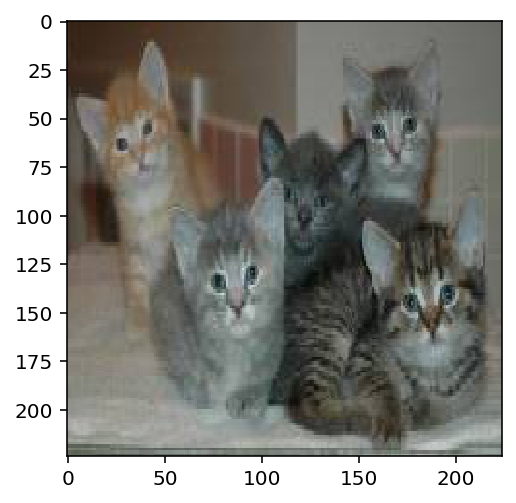

In [8]:
BATCH_SIZE = 64
IMG_SHAPE  = 224

image_gen = ImageDataGenerator(rescale=1./255)

one_image = image_gen.flow_from_directory(directory=train_dir,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                          class_mode='binary')

plt.imshow(one_image[0][0][0])
plt.show()

# Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, flip, scale, and/or crop the images in your training set. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

We can implement these transformations by passing them as arguments to the `ImageDataGenerator` class. Let's see some examples. For convenience, let's first define a plotting function that we can use to see the type of transformation that has been applied. 

In [9]:
# This function will plot images in the form of a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Flipping Images Horizontally

Let's begin by randomly applying a horizontal flip to the images in our training set. We can do this by using the `horizontal_flip=True` argument in the `ImageDataGenerator` class. Notice that we also normalize our pixel values as we did previously.

In [10]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.


Now, let's use the plotting function we defined above to see how an individual image will look after this transformation. The transformation will be randomly applied (or not) to our image. 

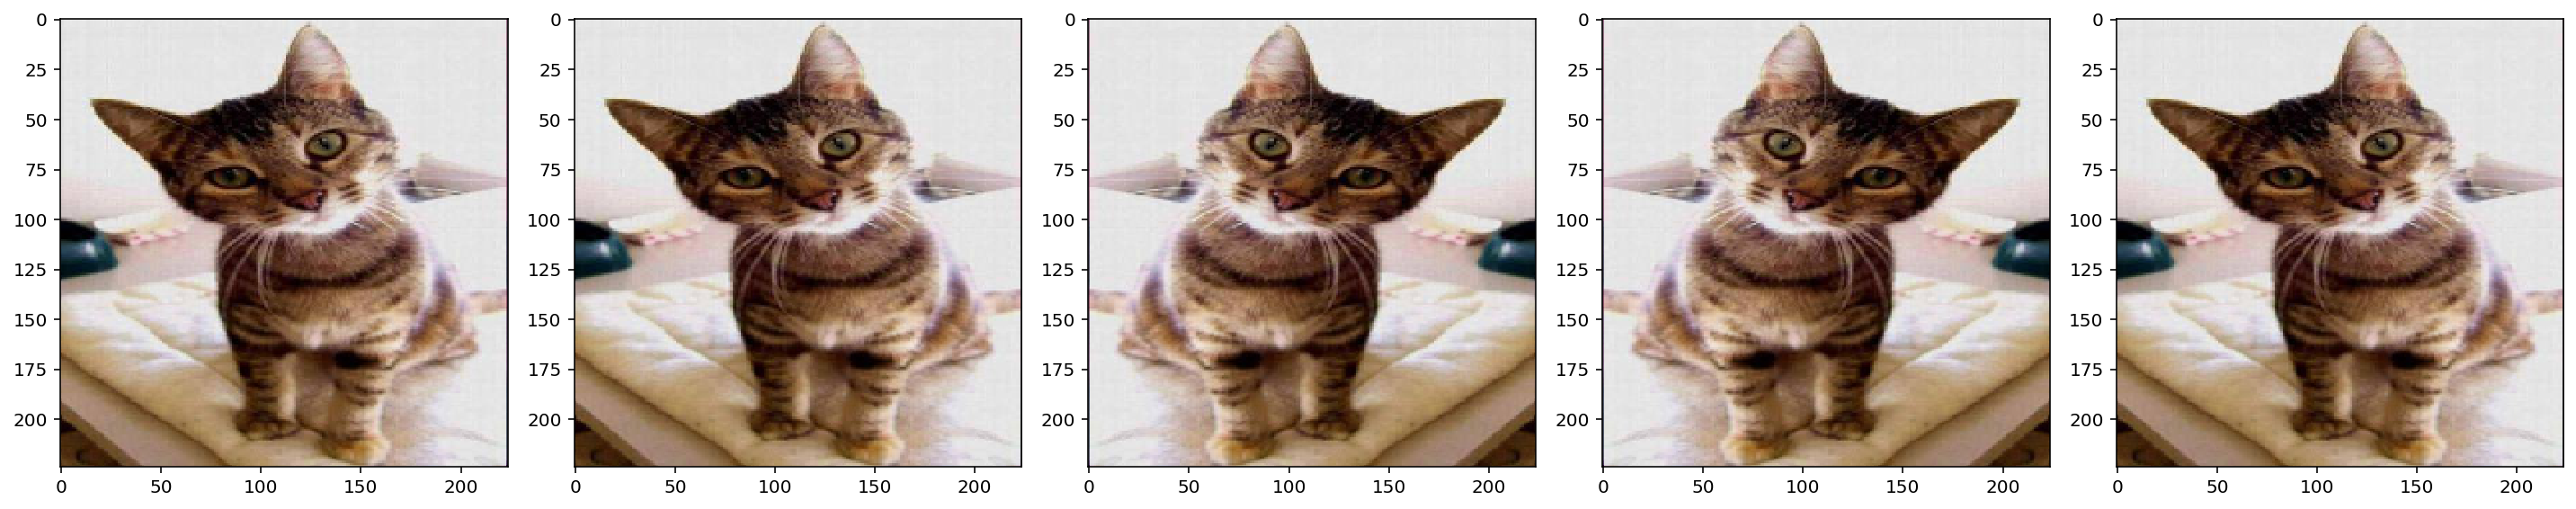

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rotating the image

Now, let's randomly rotate our images up to a specified number of degrees. We can do this by using the `rotation_range=angle` argument in the `ImageDataGenerator` class. Here, we'll set the maximum angle to be `45` degrees.

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.


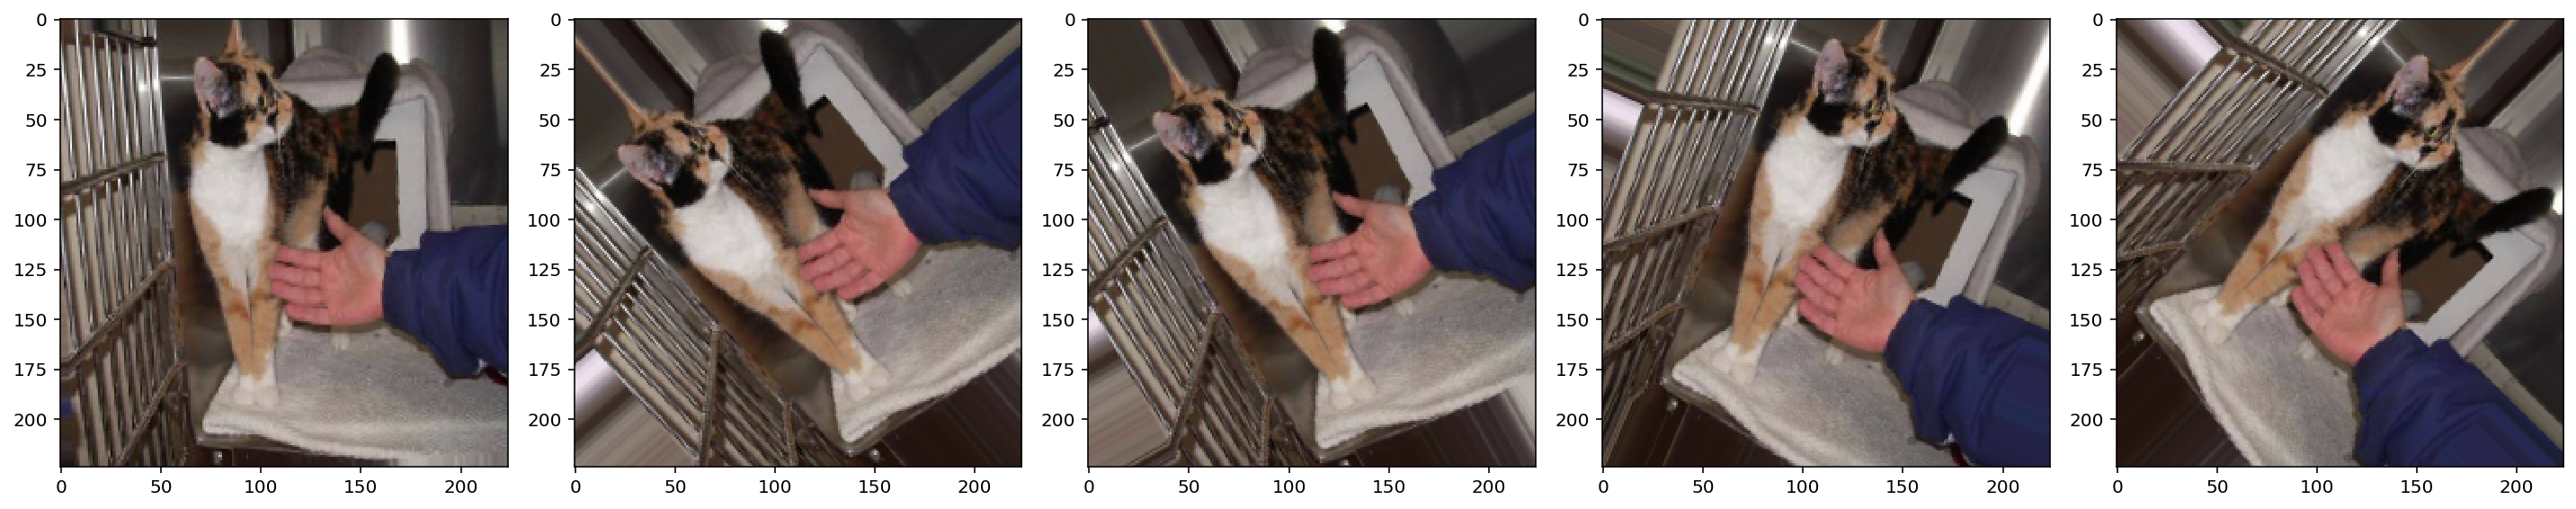

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

Now, let's randomly apply Zoom to our images. We can do this by using the `zoom_range=range` argument in the `ImageDataGenerator` class. Here, we'll set the zoom range to be `50%`.

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.


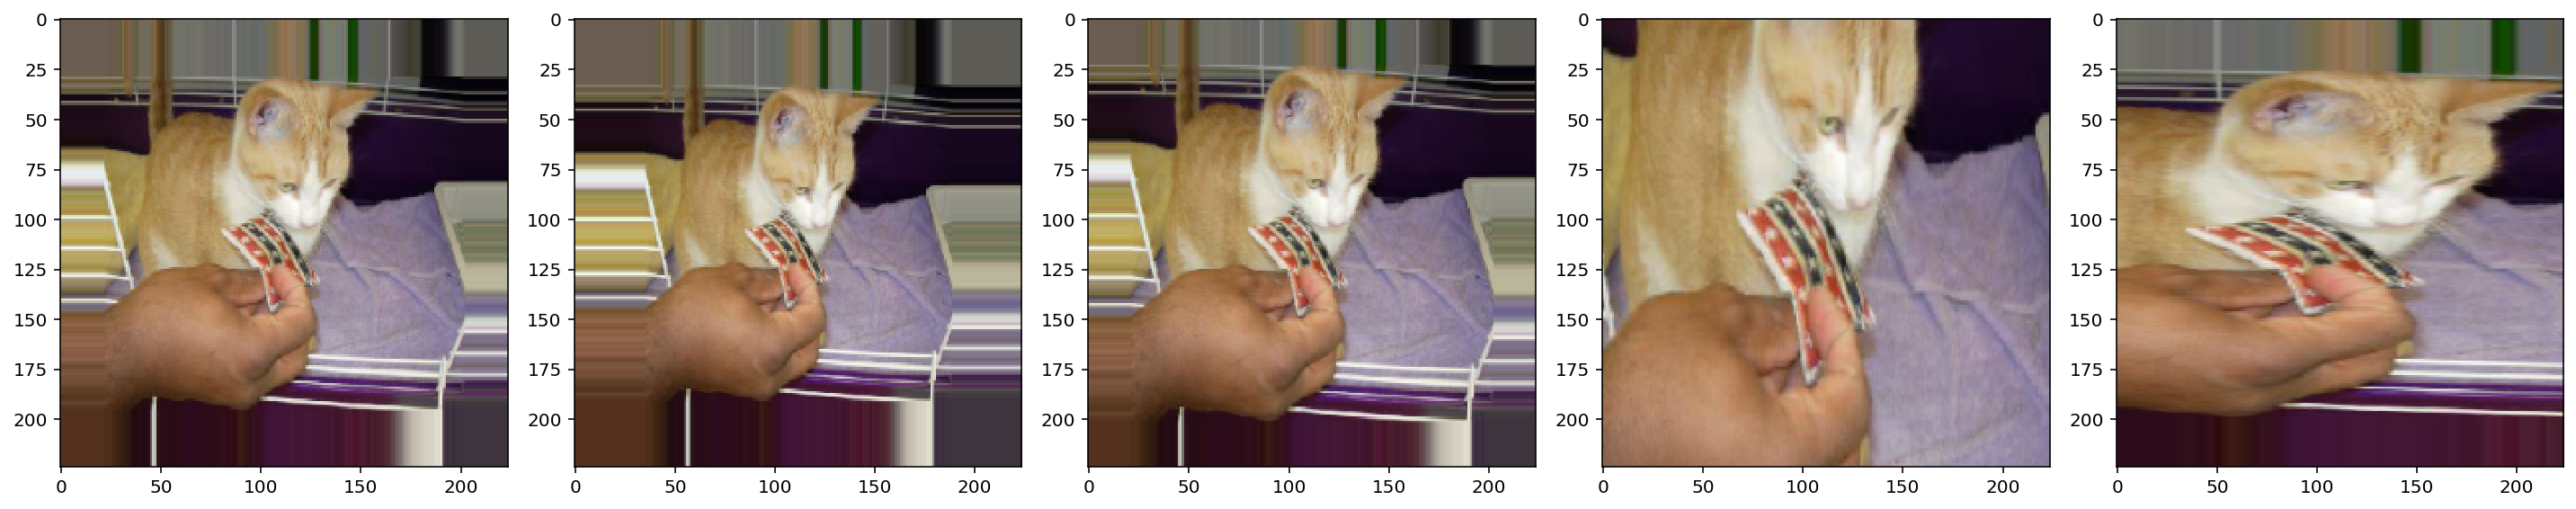

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Putting It All Together

We can pass more than one image transformation at a time to the `ImageDataGenerator` class. Therefore, we can apply all the above transformations in one go by using:

```python
image_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True
                               rotation_range=45,
                               zoom_range=0.5)
```

`tf.keras` offers many other transformations that we can apply to our images. You can take a look at all the available transformations in the [TensorFlow Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#arguments)

> **Exercise**: Now is your turn to perform image augmentation. Take a look at the [TensorFlow Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#arguments) and apply the following transformations to the training set:
* rotation_range
* width_shift_range
* height_shift_range
* shear_range
* zoom_range
* horizontal_flip
* fill_mode

> You are free to choose any values for the above parameters, along as they are valid. After creating your generator, use the `.flow_from_directory()` method to set the `batch_size`, `shuffle`, `target_size`, and `class_mode` of your pipeline.

In [23]:
## Solution
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

train_data_gen = image_gen_train.flow_from_directory(directory=train_dir,
                                       batch_size=BATCH_SIZE, 
                                       shuffle=True, 
                                       target_size=(IMG_SHAPE, IMG_SHAPE),
                                       class_mode='binary')

Found 2000 images belonging to 2 classes.


Now, let's use the plotting function we defined above to see how an individual image will look after all these transformations.

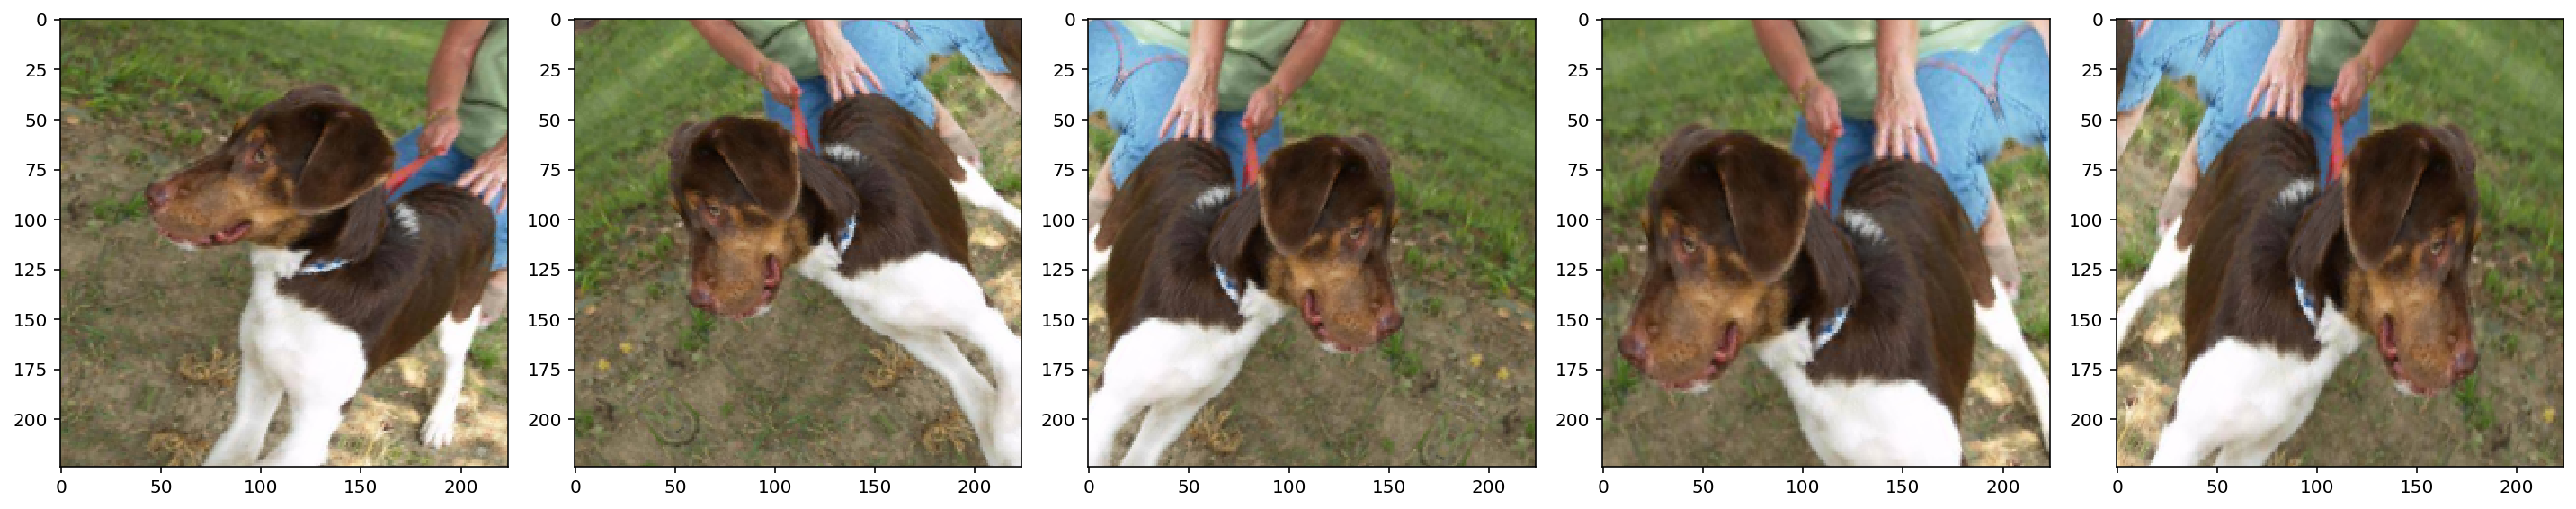

In [24]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='assets/train_examples.png' width=500px>

### Creating a Validation Data Generator

Generally, we only apply data augmentation to our training data. Therefore, for the validation set we only need to normalize the pixel values of our images.

However, we still need to specify the `batch_size`, `target_size`, and `class_mode` in the `.flow_from_directory()` method. Remember that there is no need to shuffle the validation set.

In [25]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(directory=validation_dir,
                                                 batch_size=BATCH_SIZE,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Build the Model

Now we are going to try to build a neural network that can classify the images in the dogs vs. cats dataset. 

In [26]:
layer_neurons = [1024, 512, 256, 128, 56, 28, 14]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = (IMG_SHAPE, IMG_SHAPE, 3)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
            
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              154141696 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

# Train the Model

We can configure our model for training just as we have done previously by using the `.compile()` method.

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Now, since our training batches are coming from a generator (*i.e.* the `ImageDataGenerator` class), we have to use the `.fit_generator()` method instead of the standard `.fit()` method we've used in previous notebooks to train our model.

In [28]:
EPOCHS = 10

history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen)

Epoch 1/10
32/32 [==============================] - 111s 3s/step - loss: 11.5780 - accuracy: 0.2350 - val_loss: 8.0496 - val_accuracy: 0.5000
Epoch 2/10
32/32 [==============================] - 106s 3s/step - loss: 10.6450 - accuracy: 0.3375 - val_loss: 8.0024 - val_accuracy: 0.5000
Epoch 3/10
32/32 [==============================] - 100s 3s/step - loss: 9.9947 - accuracy: 0.3740 - val_loss: 8.0496 - val_accuracy: 0.5000
Epoch 4/10
32/32 [==============================] - 100s 3s/step - loss: 9.4225 - accuracy: 0.4115 - val_loss: 8.1063 - val_accuracy: 0.5000
Epoch 5/10
32/32 [==============================] - 102s 3s/step - loss: 9.2540 - accuracy: 0.4200 - val_loss: 8.0118 - val_accuracy: 0.5000
Epoch 6/10
32/32 [==============================] - 97s 3s/step - loss: 8.9849 - accuracy: 0.4365 - val_loss: 8.0213 - val_accuracy: 0.5000
Epoch 7/10
32/32 [==============================] - 96s 3s/step - loss: 8.8152 - accuracy: 0.4500 - val_loss: 8.0307 - val_accuracy: 0.5000
Epoch 8/10
32

# TODO (Optional): Attempt to Build a Network that Can Classify the Dogs vs. Cats  Dataset

As we can see above, the accuracy achieved by the end of training is less than 50\%, which is not very good. So, your task is to try to build a neural network that can classify the images in the Dogs vs. Cats  Dataset with high accuracy.

You will notice that this is quite a bit more complicated than what you did before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and have a higher resolution than the 28 $\times$ 28 images of the MNIST and Fashion-MNIST datasets.

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [31]:
layer_neurons = [1024, 512, 256, 256, 128, 56, 28, 14, 8]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = (IMG_SHAPE, IMG_SHAPE, 3)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.35))
            
model.add(tf.keras.layers.Dense(10, activation='softmax'))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 20

history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 122s 4s/step - loss: 10.8463 - accuracy: 0.2490 - val_loss: 8.1157 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 96s 3s/step - loss: 9.8216 - accuracy: 0.3460 - val_loss: 8.0213 - val_accuracy: 0.5000
Epoch 3/20
32/32 [==============================] - 98s 3s/step - loss: 8.8515 - accuracy: 0.4060 - val_loss: 8.0496 - val_accuracy: 0.5000
Epoch 4/20
32/32 [==============================] - 96s 3s/step - loss: 9.3023 - accuracy: 0.3940 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 5/20
32/32 [==============================] - 97s 3s/step - loss: 8.6261 - accuracy: 0.4275 - val_loss: 8.0496 - val_accuracy: 0.5000
Epoch 6/20
32/32 [==============================] - 97s 3s/step - loss: 8.3558 - accuracy: 0.4405 - val_loss: 8.0213 - val_accuracy: 0.5000
Epoch 7/20
32/32 [==============================] - 98s 3s/step - loss: 8.2616 - accuracy: 0.4570 - val_loss: 8.0874 - val_accuracy: 0.5000
Epoch 8/20
32/32 [